# Vyshyvanka plot code and examples

For the article "On the visualization of longitudinal data"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random

import seaborn as sns

## Common ways

In [2]:
def plot_common(df):
    """ Plot individual trends, boxplot and violinplot for longitudinal data
    """
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.patch.set_facecolor('white')
    fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=1.0, w_pad=0.94)
    fig.suptitle(f'BP groups over time (n={df.shape[1]})', weight='bold')    
    
    # individual trends
    for i in df:
        axs[0].plot(df[i])
    # boxplot and violin
    ax = sns.boxplot(ax=axs[1], data=df.T, medianprops={'lw': 4})
    ax = sns.violinplot(ax=axs[2], data=df.T, scale='count', inner='box')

    for ax in axs:
        _ = ax.set_yticks(np.unique(df0))
        _ = ax.set_ylabel('BP group')
        
    _ = axs[-1].set_xlabel('Time point')

In [3]:
# for reproducibility
random.seed(999)

# create dataset
patients = 1000
time_points = 6
groups = [1, 2, 3, 4, 5]

# state distribution splits from initial 3 to 1 and 5
tmp = []
for _ in range(time_points):
    x = np.array(random.choices(groups, k=patients, weights=[0.01, 0.48, 0.02, 0.48 ,0.01]))
    tmp.append(x)

df0 = pd.DataFrame(tmp)
df0

0    1    2    3    4    5    6    7    8    9    ...  990  991  992  993  \
0    4    2    4    4    3    2    4    2    4    4  ...    2    4    4    4   
1    4    2    2    4    4    2    4    2    4    4  ...    4    4    4    2   
2    2    2    5    2    2    4    4    4    2    1  ...    4    4    2    2   
3    2    2    2    2    2    3    4    4    2    2  ...    4    4    3    4   
4    4    4    4    4    2    4    4    4    4    4  ...    4    4    4    2   
5    2    4    2    4    4    2    2    2    2    2  ...    4    2    2    4   

   994  995  996  997  998  999  
0    4    4    4    4    2    2  
1    2    4    2    4    4    4  
2    2    4    2    4    4    4  
3    2    2    4    4    2    4  
4    4    3    4    4    4    4  
5    4    4    4    2    2    2  

[6 rows x 1000 columns]

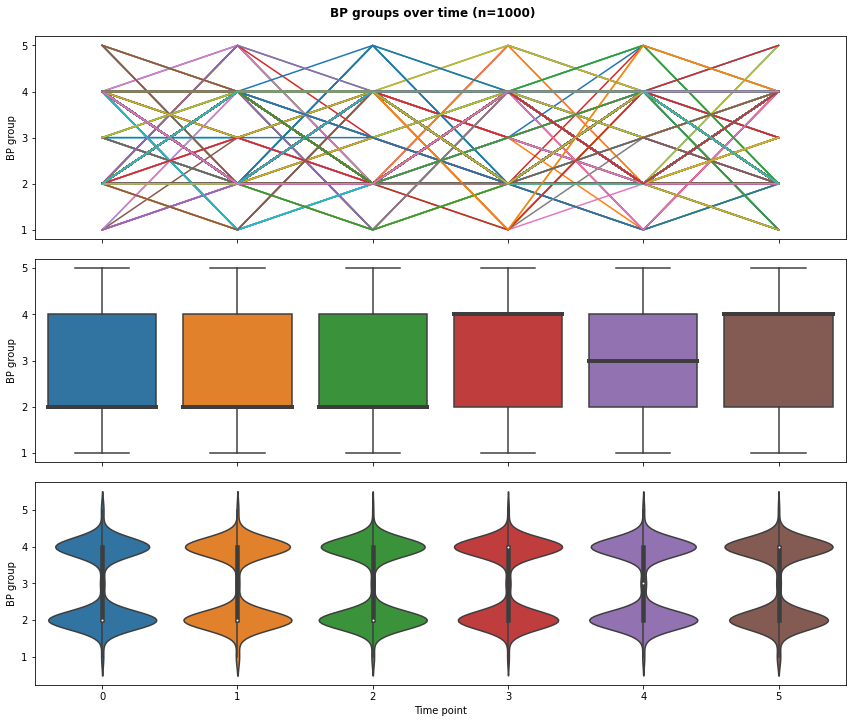

In [4]:
plot_common(df0)

## Vyshyvanka plot

In [5]:
def plot_vyshyvanka(df: pd.DataFrame, ax: plt.Axes,
                    coef_width=50, line_opacity=0.6, marker_opacity=0.1) -> (plt.Axes, int, np.ndarray):
    """
        It will build the flow plot "Vyshyvanka": the transitions between possible states of
        observations on the X-axis over some time periods on the Y-axis.
            
        Line width and marker opacity correlate with the number of observations at a current point.
        
    
        :param df: dataframe where columns are observations and rows are time points
        :param ax: an instance of ``matplotlib.axes.Axes`` to plot on
        :param coef_width: the bigger it, the thicker will be the lines
        :param line_opacity: lines opacity
        :param marker opacity: markers opacity
        
        :return: (``matplotlib.axes.Axes``, number_of_observations_without_na, possible_states)
        
        **Example:**
        
        .. code-block:: python
        
            import random
            import pandas as pd
            import matplotlib.pyplot as plt
            
        
            obs_num = 1000
            time_points = 8
            states = [1, 2, 3, 4, 5]

            tmp = [] 
            for _ in range(time_points):
                tmp.append(random.choices(states, k=obs_num,
                                          weights=[0.05, 0.2 ,0.5, 0.2 ,0.05]))

            df = pd.DataFrame(tmp)


            fig, ax = plt.subplots(figsize=(15, 7))
            fig.patch.set_facecolor('white')

            ax, num, relevant_states = plot_vyshyvanka(df, ax)
            _ = ax.set_yticks(relevant_states)
            _ = ax.set_xlabel('Time points')
            _ = ax.set_ylabel('States')
            _ = ax.set_title(f'State transitions over time (n={num})')
        
        
    """
    # drop observations with NA an count what left
    df_plot = df.dropna(axis=1)
    obs_num = len(df_plot.columns)
    
    # iterate over time points using sliding window with length=2, stride=1
    for row1, row2 in zip(itertools.islice(df_plot.iterrows(), 0, None, 1),
                          itertools.islice(df_plot.iterrows(), 1, None, 1)):
        # get row idxs (from df.iterrows() output)
        x1 = row1[0]
        x2 = row2[0]
        # get row values
        tmp = pd.concat([row1[1], row2[1]], axis=1).to_numpy()
        # count unique pairs was-now states
        pairs, nums = np.unique(tmp, axis=0, return_counts=True)
        # get all possible states
        states = np.unique(pairs.flatten())
        # calculate line widths for each pair (state transition)
        # line width correlates with observations amount,
        # where ``obs_num * coef_width`` is the maximum width
        widths = nums / obs_num * coef_width

        # add axis to widths in order to merge it with pairs for comfy iteration
        for row in np.hstack([pairs, np.expand_dims(widths, axis=1)]):
            y1, y2, w = row
            # plot line
            ax.plot([x1, x2], [y1, y2], linewidth=w, color='red', alpha=line_opacity, solid_capstyle='round')
            # plot markers
            # marker opacity correlates with observations amount
            ax.plot(x1, y1, 'o', markersize=2, color='black', alpha=marker_opacity)
            ax.plot(x2, y2, 'o', markersize=2, color='black', alpha=marker_opacity)
    
    return ax, obs_num, states


def plot_vyshyvanka_wrapper(df):
    """ A wrapper around plot_vyshyvanka
        Which will set some style settings like ticks and labels
    """
    fig, ax = plt.subplots(figsize=(15, 7))
    fig.patch.set_facecolor('white')

    ax, obs_num, states = plot_vyshyvanka(df, ax)
    _ = ax.set_yticks(states)
    _ = ax.set_xlabel('Time points')
    _ = ax.set_ylabel('BP group')
    _ = ax.set_title(f'BP group transition over time (n={obs_num})')

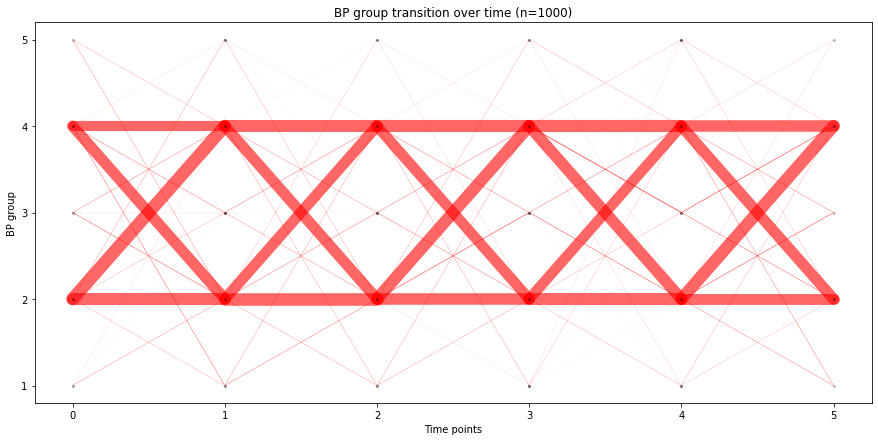

In [6]:
plot_vyshyvanka_wrapper(df0)

In [7]:
def plot_violins_and_vyshyvanka(df):
    """ Wrapper function around plot_vyshyvanka and violinplot
    """
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.patch.set_facecolor('white')
    fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=1.0, w_pad=0.94)

    ax = sns.violinplot(ax=axs[0], data=df.T, scale='count', inner='box')
    ax, obs_num, states = plot_vyshyvanka(df, axs[1])
    _ = axs[1].set_xlabel('Time points')
    
    for ax in axs:
        _ = ax.set_yticks(states)
        _ = ax.set_ylabel('States')
        
    fig.suptitle(f'State transitions over time (n={obs_num})', weight='bold')

Here we will create dataset with a weightened random distrubutions of states.

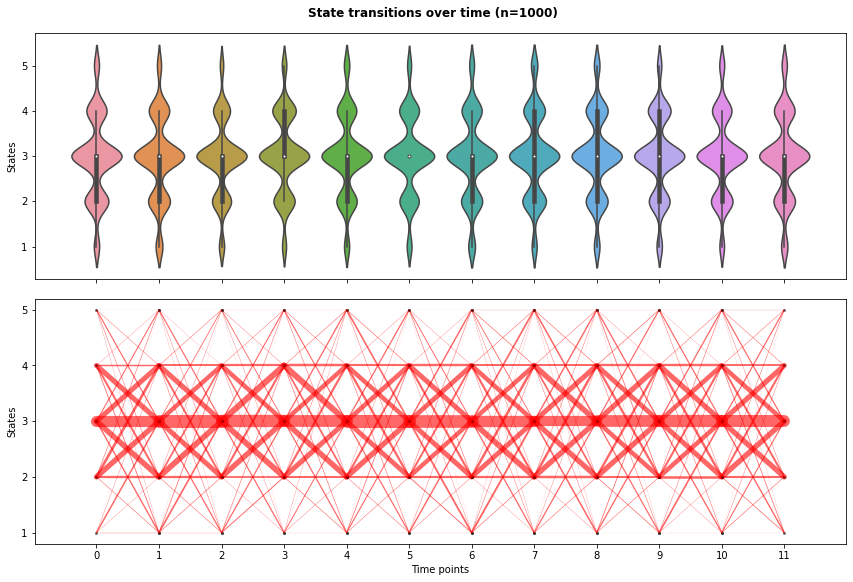

In [8]:
# standard case with a strong trend and a little flucuations around
# somewhat like normal uninteresting situation

random.seed(999)

obs_num = 1000
time_points = 12
states = [1, 2, 3, 4, 5]


tmp = [] 
for _ in range(time_points):
    tmp.append(random.choices(states, k=obs_num, weights=[0.05, 0.2 ,0.5, 0.2 ,0.05]))

df1 = pd.DataFrame(tmp)


plot_violins_and_vyshyvanka(df1)

Here and below we will create dataset with a weightened random distrubutions of states, but the change could be no more than one step up or down.

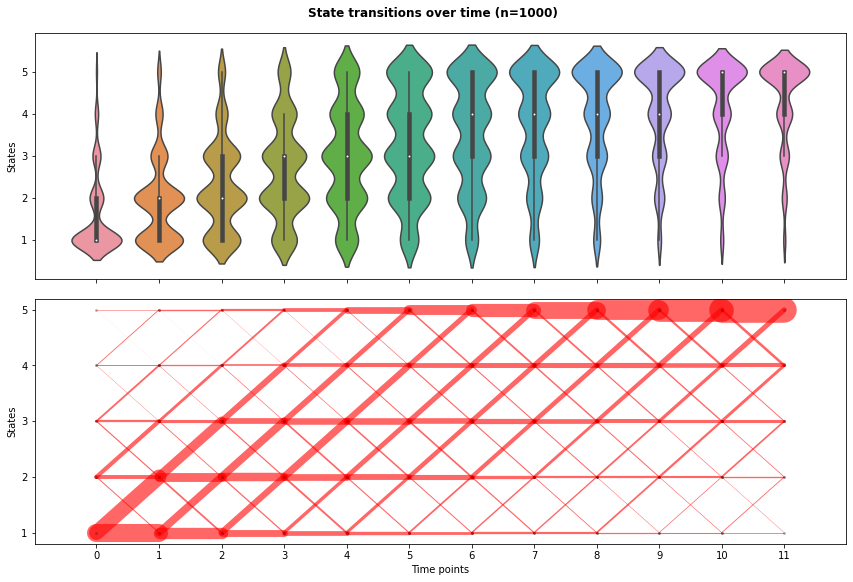

In [9]:
# state distribution changes from primary 1 to primary 5

random.seed(999)

obs_num = 1000
time_points = 12
states = [1, 2, 3, 4, 5]

tmp = [] 
x = np.array(np.array(random.choices(states, k=obs_num, weights=[0.64, 0.2, 0.1, 0.05, 0.01])))
tmp.append(x)
for _ in range(time_points - 1):
    x = x + np.array(random.choices([-1, 0, 1], k=obs_num, weights=[0.1, 0.45, 0.45]))
    x = np.clip(x, 1, 5)
    tmp.append(x)
    
df2 = pd.DataFrame(tmp)

plot_violins_and_vyshyvanka(df2)

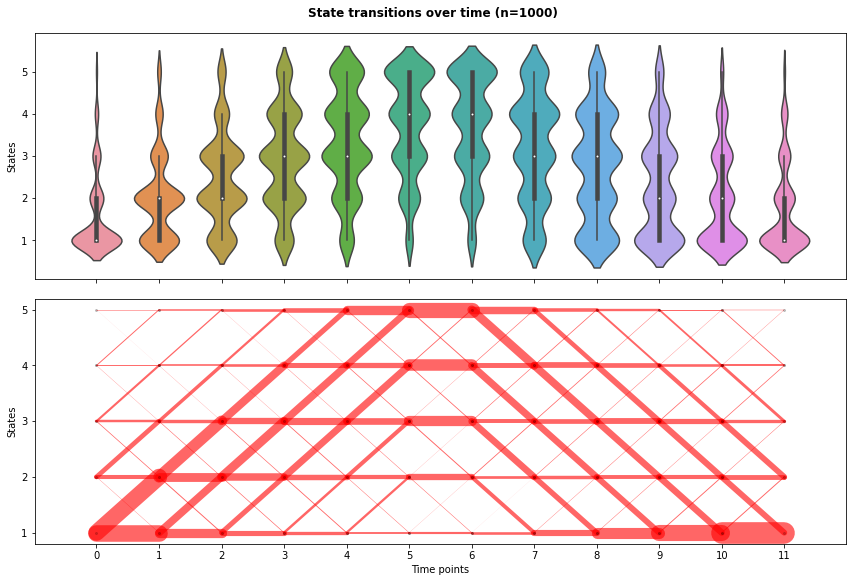

In [10]:
# state distribution changes from primary 1 to primary 5 and back to 1

random.seed(999)

obs_num = 1000
states = [1, 2, 3, 4, 5]

tmp = [] 
x = np.array(np.array(random.choices(states, k=obs_num, weights=[0.64, 0.2 ,0.1, 0.05 ,0.01])))
tmp.append(x)
for _ in range(5):
    x = x + np.array(random.choices([-1, 0, 1], k=obs_num, weights=[0.05, 0.45, 0.5]))
    x = np.clip(x, 1, 5)
    tmp.append(x)
    
x = x + np.array(random.choices([-1, 0, 1], k=obs_num, weights=[0.05, 0.9, 0.05]))
x = np.clip(x, 1, 5)
tmp.append(x)
for _ in range(5):
    x = x + np.array(random.choices([-1, 0, 1], k=obs_num, weights=[0.55, 0.4, 0.05]))
    x = np.clip(x, 1, 5)
    tmp.append(x)
    
df3 = pd.DataFrame(tmp)

plot_violins_and_vyshyvanka(df3)

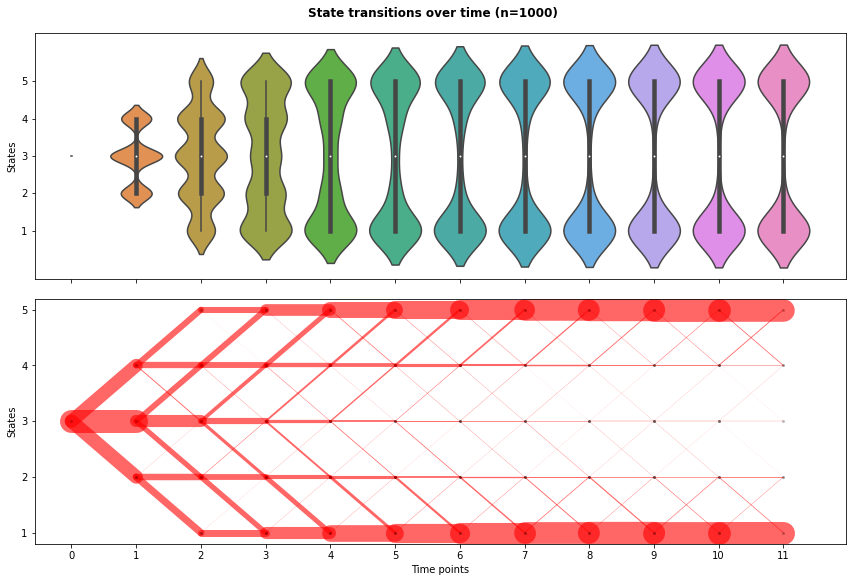

In [11]:
# state distribution splits from primary 3 to primary 1 and 5

random.seed(999)

obs_num = 1000
time_points = 12
states = [1, 2, 3, 4, 5]

# state distribution splits from initial 3 to 1 and 5
tmp = []
x = np.array(random.choices(states, k=obs_num, weights=[0, 0, 1, 0 ,0]))
tmp.append(x)

for _ in range(time_points - 1):
    x = x + np.array([random.choices([-1, 0, 1], k=int(obs_num/2), weights=[0.02, 0.48, 0.5]),
                      random.choices([-1, 0, 1], k=int(obs_num/2), weights=[0.5, 0.48, 0.02])]).ravel()
    x = np.clip(x, 1, 5)
    tmp.append(x)


df4 = pd.DataFrame(tmp)

plot_violins_and_vyshyvanka(df4)